In [17]:
import fluxy as fl
from influxdb_client.client.influxdb_client_async import InfluxDBClientAsync
from dotenv import load_dotenv
import os
from datetime import datetime, timezone, timedelta

load_dotenv()

API_TOKEN = os.getenv("ENERGY_REPORT_API_TOKEN")
# electricity generated
# heat generated
# grid import -> 0 hopefully
# battery level
# cooling demand
# fancoil settings
# water consumption

In [18]:
start = datetime.now(timezone.utc) - timedelta(days=7)
stop = datetime.now(timezone.utc)

In [19]:
from pandas import DataFrame


async def query(fl) -> DataFrame:
  async with InfluxDBClientAsync("https://influxdb.prod.power-hub.foundationzero.org", API_TOKEN, "power_hub") as client:
    print(fl.to_flux())
    return await client.query_api().query_data_frame(fl.to_flux())

In [24]:
window_size = timedelta(minutes=10)

q = fl.pipe(
  fl.from_bucket("power_hub"),
  fl.range(start, stop),
  fl.filter(fl.conform({"_field": "electrical_pv_power"})),
  fl.aggregate_window(window_size, fl.WindowOperation.MEAN, False),
  fl.keep(["_time", "_value", "_field"]),
  fl.pivot(["_time"], ["_field"], "_value"),
)
pv_power = (await query(q)).resample(timedelta(days=1), on="_time").mean(numeric_only=True)
pv_yield = pv_power.assign()

from(bucket: "power_hub")
|> range(start: 2024-08-23T13:17:30.829064+00:00, stop: 2024-08-30T13:17:30.829088+00:00)
|> filter(fn: (r) => r["_field"] == "electrical_pv_power")
|> aggregateWindow(every: 600s, fn: mean, createEmpty: false)
|> keep(columns: ["_time", "_value", "_field"])
|> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")


,table,electrical_pv_power
_time,,
2024-08-23 00:00:00+00:00,0.0,6116.588744
2024-08-24 00:00:00+00:00,0.0,7992.564073
2024-08-25 00:00:00+00:00,0.0,11271.616253
2024-08-26 00:00:00+00:00,0.0,8933.427725
2024-08-27 00:00:00+00:00,0.0,7802.555104
2024-08-28 00:00:00+00:00,0.0,9417.353698
2024-08-29 00:00:00+00:00,0.0,7229.059125
2024-08-30 00:00:00+00:00,0.0,10289.634678


In [11]:
import pandas as pd

estimates = pd.read_csv("../energy_box_control/power_hub/powerhub_simulation_schedules_Jun_Oct_TMY.csv").rename({'Unnamed: 0': "time"}, axis=1)

<Axes: xlabel='time'>

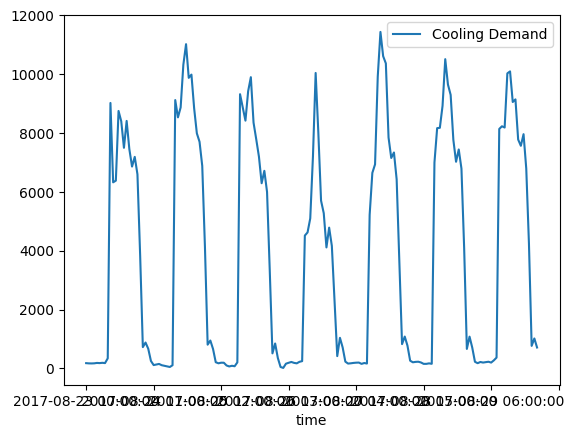

In [12]:
estimates[(estimates['time'] > '2017-08-23') & (estimates['time'] < '2017-08-30')].plot(x='time', y='Cooling Demand')


In [14]:
estimates['Cooling Demand'].sum()

10693556.494278304